In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/hymenoptera/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

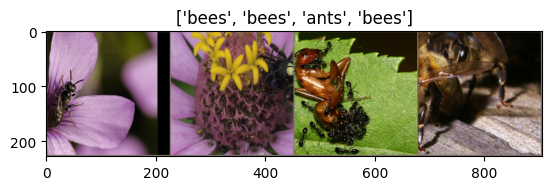

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [4]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


### Resnet 18 - without regularization

In [ ]:
import copy 
import torch
import time
from torch import nn, optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

model_ft, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6876 Acc: 0.6434
val Loss: 0.5311 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.6266 Acc: 0.7787
val Loss: 0.5232 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5620 Acc: 0.8115
val Loss: 0.6036 Acc: 0.8170

Epoch 3/24
----------
train Loss: 0.6542 Acc: 0.7295
val Loss: 0.4767 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.6268 Acc: 0.7541
val Loss: 0.2357 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4120 Acc: 0.8156
val Loss: 0.3769 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.4764 Acc: 0.8074
val Loss: 0.3786 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4216 Acc: 0.8279
val Loss: 0.2811 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3398 Acc: 0.8730
val Loss: 0.2240 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2895 Acc: 0.8770
val Loss: 0.2215 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3421 Acc: 0.8402
val Loss: 0.1635 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3038 Acc: 0.8934
val Loss: 0.1763 Acc: 0.9412

Ep

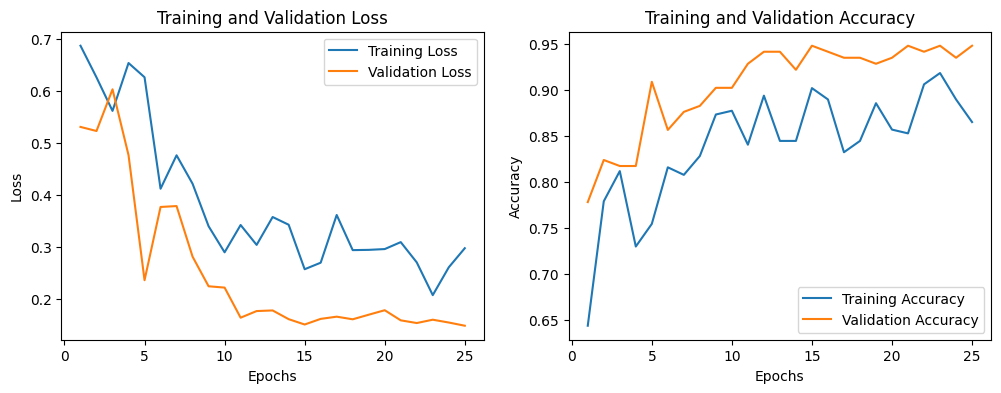

In [ ]:
epochs = range(1, 26)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label='Training Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label='Training Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


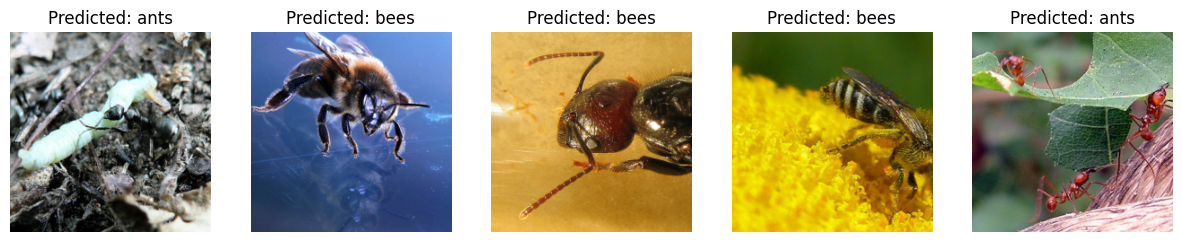

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_predictions(model, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.show()
                    return

visualize_predictions(model_ft)


In [8]:
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    overall_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
    print(f"Overall Accuracy: {overall_acc:.4f}")

generate_classification_report(model_ft, dataloaders['val'])

Classification Report:
              precision    recall  f1-score   support

        ants       0.94      0.94      0.94        70
        bees       0.95      0.95      0.95        83

    accuracy                           0.95       153
   macro avg       0.95      0.95      0.95       153
weighted avg       0.95      0.95      0.95       153

Overall Accuracy: 0.9477


### Cross Entropy with L2 regularization. 

In [ ]:
import copy 
import torch
import time
from torch import nn, optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def compute_l2_penalty(model):
    l2_reg = torch.tensor(0., requires_grad=True).to(device)
    for param in model.parameters():
        l2_reg = l2_reg + torch.norm(param, 2)**2
    return l2_reg

def train_model_l2(model, criterion, optimizer, scheduler, num_epochs=25, l2_lambda=0.01):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    main_loss = criterion(outputs, labels)
                    
                    l2_penalty = compute_l2_penalty(model)
                    loss = main_loss + l2_lambda * l2_penalty

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

model_ft, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model_l2(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, l2_lambda=0.2)


Epoch 0/24
----------
train Loss: 1213.1016 Acc: 0.8074
val Loss: 935.6895 Acc: 0.9020

Epoch 1/24
----------
train Loss: 732.5996 Acc: 0.8484
val Loss: 556.0858 Acc: 0.7386

Epoch 2/24
----------
train Loss: 435.2881 Acc: 0.8525
val Loss: 330.4425 Acc: 0.8235

Epoch 3/24
----------
train Loss: 258.8107 Acc: 0.8115
val Loss: 196.4973 Acc: 0.8627

Epoch 4/24
----------
train Loss: 154.0246 Acc: 0.7910
val Loss: 117.4762 Acc: 0.6667

Epoch 5/24
----------
train Loss: 91.9881 Acc: 0.7295
val Loss: 70.0866 Acc: 0.7386

Epoch 6/24
----------
train Loss: 55.1820 Acc: 0.6311
val Loss: 42.1644 Acc: 0.5556

Epoch 7/24
----------
train Loss: 41.0661 Acc: 0.6885
val Loss: 40.0056 Acc: 0.7059

Epoch 8/24
----------
train Loss: 39.0746 Acc: 0.6844
val Loss: 38.0709 Acc: 0.7124

Epoch 9/24
----------
train Loss: 37.1704 Acc: 0.7295
val Loss: 36.2098 Acc: 0.7190

Epoch 10/24
----------
train Loss: 35.3788 Acc: 0.6926
val Loss: 34.4692 Acc: 0.7451

Epoch 11/24
----------
train Loss: 33.6522 Acc: 0.754

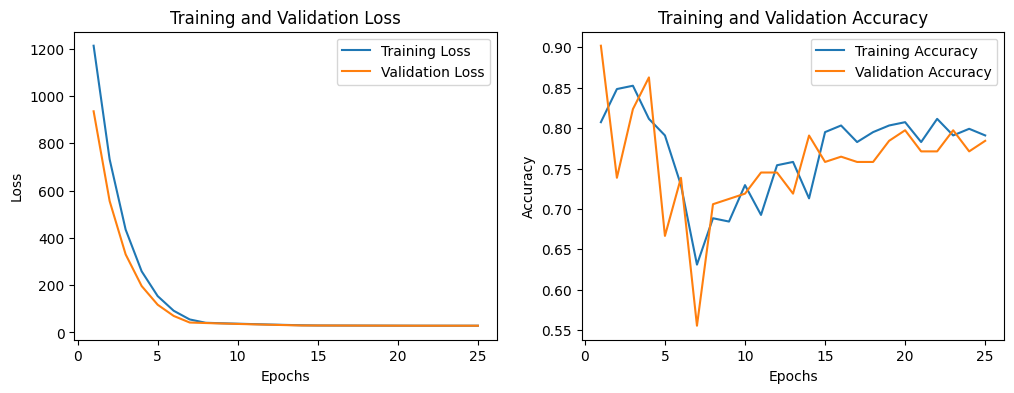

In [ ]:
epochs = range(1, 26)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label='Training Loss')
plt.plot(epochs, val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label='Training Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

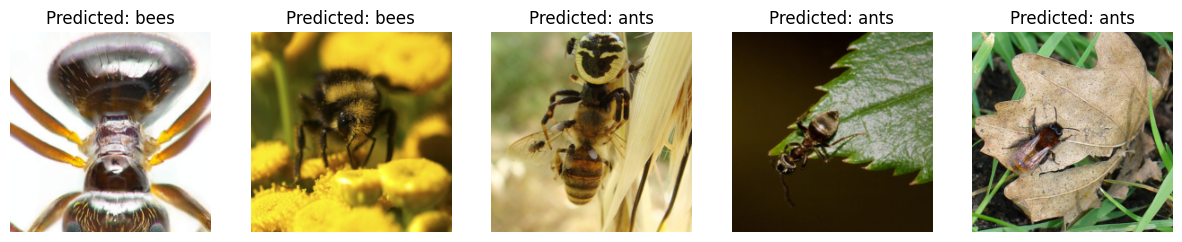

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_predictions(model, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.show()
                    return

visualize_predictions(model_ft)


In [ ]:
from sklearn.metrics import classification_report

def generate_classification_report(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    overall_acc = (np.array(true_labels) == np.array(pred_labels)).mean()
    print(f"Overall Accuracy: {overall_acc:.4f}")

generate_classification_report(model_ft, dataloaders['val'])

Classification Report:
              precision    recall  f1-score   support

        ants       0.89      0.90      0.89        70
        bees       0.91      0.90      0.91        83

    accuracy                           0.90       153
   macro avg       0.90      0.90      0.90       153
weighted avg       0.90      0.90      0.90       153

Overall Accuracy: 0.9020


In [ ]:
import subprocess
# Add this file to git, commit and push 
subprocess.run(['git','add','.'])
subprocess.run(['git','commit','-m','Final commits'])
subprocess.run(['git','push'])


CompletedProcess(args=['git', 'push'], returncode=0)

In [ ]:
import subprocess
import random
import json

# Path to the Jupyter Notebook file
notebook_path = "trial/transfer_trial.ipynb"

# List of fake commit messages
commit_messages = [
    "Fix minor bugs",
    "Improve performance",
    "Add new features",
    "Refactor codebase",
    "Update README",
    "Improve documentation",
    "Code optimization",
    "Add tests",
    "Fix typos",
    "Minor adjustments"
]

# Number of fake commits
num_commits = 15

def add_dummy_cell(notebook_path, content):
    """Add a dummy code cell to the Jupyter notebook."""
    # Read the existing notebook
    with open(notebook_path, "r") as file:
        notebook_data = json.load(file)

    # Create a dummy cell
    dummy_cell = {
        "cell_type": "code",
        "execution_count": None,
        "metadata": {},
        "outputs": [],
        "source": [content]
    }

    # Add the dummy cell to the notebook
    notebook_data['cells'].append(dummy_cell)

    # Write back to the notebook
    with open(notebook_path, "w") as file:
        json.dump(notebook_data, file, indent=2)

# Generate multiple commits
for i in range(num_commits):
    # Add a dummy cell with random content
    content = f"# Cell {i + 1}: Value {random.randint(1, 1000)}\n"
    add_dummy_cell(notebook_path, content)

    # Stage all changes
    subprocess.run(['git', 'add', '.'])

    # Randomly pick a commit message
    commit_message = random.choice(commit_messages)

    # Create a commit
    subprocess.run(['git', 'commit', '-m', commit_message])

# Push all the commits to the remote repository
subprocess.run(['git', 'push'])


END